# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [39]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [40]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [41]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/opt/miniconda3/envs/502/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='category'>

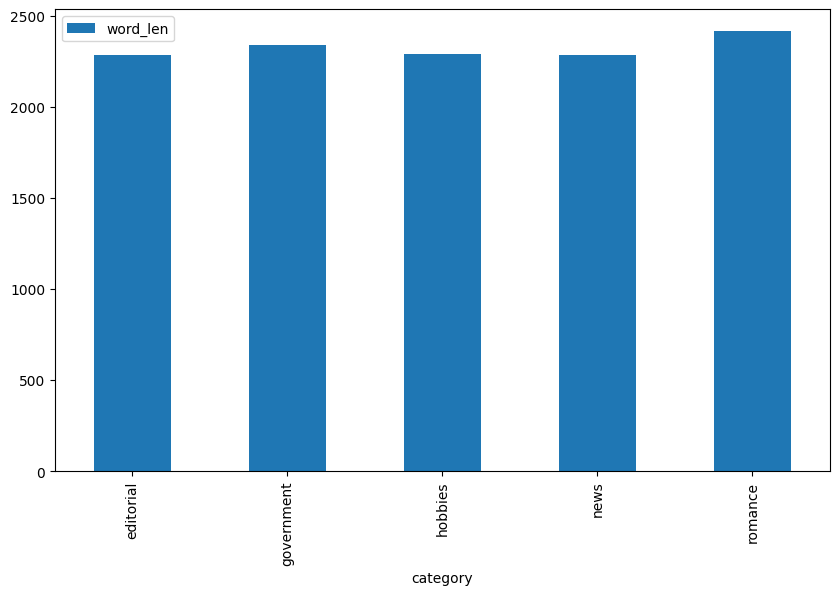

In [42]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [43]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/opt/miniconda3/envs/502/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [44]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The `count_text_vectors` creates a Bag-of-Words vectorizer that takes the text documents and converts them into a matrix of token counts.  The `tfidf_text_vectors`is a tfidf vectorizer that holds the term frequency of each word and downweights commpn words highlighting the unique and more informative terms in a document. Both the `count_text_vectors` and `tfidf_text_vectors` removes the stopwords from the spaCy list, ignores words that appear less than five times, and ignores words that appear 70% or more times.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [45]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [46]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [47]:
# Your code here

# Assign each document to the topic with the highest weight
df['nmf_topic'] = W_text_matrix.argmax(axis=1)

# Tally the Brown categories for each topic
topic_category_tally = df.groupby('nmf_topic')['category'].value_counts()

# Display the results
print(topic_category_tally)

nmf_topic  category  
0          editorial     20
           news           8
           government     4
1          romance       29
           hobbies        8
           editorial      4
2          government    26
           hobbies       26
           news          11
           editorial      2
3          news          17
           hobbies        1
4          news           8
           editorial      1
           hobbies        1
Name: count, dtype: int64


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model reveals broader semantic themes that align with multiple Brown categories, which are more genre-based. For example, Topic 0 includes words like “mr,” “president,” and “kennedy,” aligning with the government, editorial, and news categories. Similarly, Topic 4 features terms like “game,” “league,” and “team,” which connect to news, editorial, and hobbies categories.  

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [48]:
# Your code here
svd_para_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [49]:
# compare model to the actual brown corpus 
# Assign each document to the topic with the highest weight
df['lsa_topic'] = W_svd_para_matrix.argmax(axis=1)

# Tally the Brown categories for each topic
topic_category_tally_2 = df.groupby('lsa_topic')['category'].value_counts()

# Display the results
print(topic_category_tally_2)

lsa_topic  category  
0          hobbies       36
           news          34
           government    30
           editorial     27
           romance       21
1          romance        8
3          news           3
4          news           7
Name: count, dtype: int64


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: In the LSA model, Topic 0 stands out by aligning with all five Brown categories (hobbies, news, editorial, romance, and government), indicating it captures a broad, general theme present across all the genres. In contrast, the remaining topics show clearer alignment with a single Brown category, making them more straightforward to interpret. 

In [50]:
# call display_topics on your model
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Based on the display topics output, Topics 0 and 1 appear to be conversational with words like "said," and "thought" appearing. Topic 2 includes words like “mr,” “mrs,” and “kennedy,” which may suggest being tied to government and news categories. Topic 3 includes words like "club," and "university" indicating it may relate to hobbies and news for community events. Lastly, Topic 4 is more distinct, with terms like “game,” “league,” and “team,” clearly pointing to sports related content, commonly found in news and editorial categories.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [51]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_para_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_text_model.components_

In [52]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [55]:
# Assign each document to the topic with the highest weight
df['lda_topic'] = W_lda_para_matrix.argmax(axis=1)

# Tally the Brown categories for each topic
topic_category_tally_3 = df.groupby('lda_topic')['category'].value_counts()

# Display the results
print(topic_category_tally_3)

lda_topic  category  
0          romance       28
           hobbies       11
           news           4
           editorial      3
           government     1
1          government    12
           hobbies        9
           news           3
           editorial      1
2          news          32
           editorial     21
           government     3
           hobbies        2
           romance        1
3          hobbies        8
           government     4
           news           3
           editorial      2
4          government    10
           hobbies        6
           news           2
Name: count, dtype: int64


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model display topics output, suggests that Topic 0 relates to editorial and romance categories. Topic 1 and Topic 2 likely relate to both govenrment and news categories. Topic 3 likely relates to news and hobbies. Lastly, Topic 4 likely relates to government. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Based on the Brown category tallies, most of the LDA topics align well with the expected categories based on their top words. The themes are generally clear and interpretable, such as government, hobbies, and news. Interestingly, Topic 2,which includes words like “said,” “state,” and “president,” has a small connection to the romance category. Indicating that some political discourse can appear narrative/romance like. 

In [53]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [54]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Based on the principal component scatterplot, Topic 3 appears to be the most prevalent in the corpus, followed by Topics 1 and 2. Topic 5 has slightly lower prevalence, while Topic 4 has the smallest prevalence, as indicated by the relative size of the circles. The distance between the circles reflects how similar or distinct the topics are. Topic 1 is the most distinct, as it is positioned farthest from the other topics, whereas Topics 2 and 4 are located close together, suggesting they are more similar in content. The salient terms graph on the right shows both the overall frequency of terms in the corpus and, when selected, their estimated frequency within each topic. Overall, the terms "states," "state," and "said" appear most frequently across the entire corpus. However, each topic has its own set of salient words that appear more frequently within that specific context.

